In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [5]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 23.29 23.43 23.57 23.71 ... 1.506 1.446 1.387 1.33

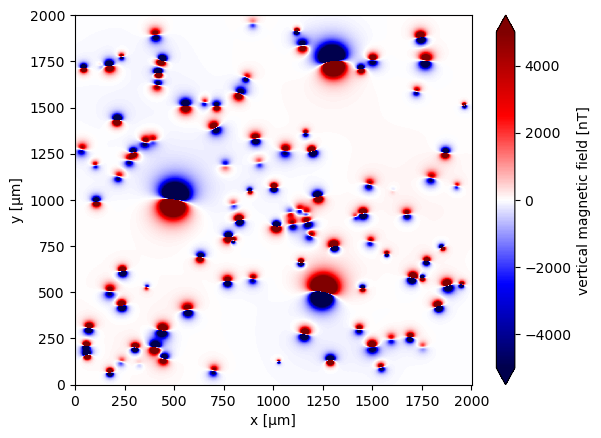

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

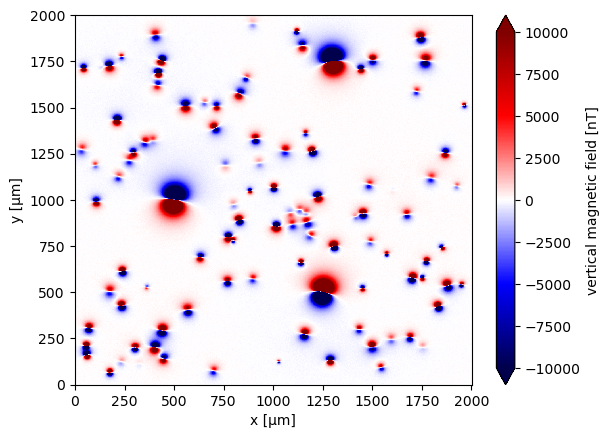

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999

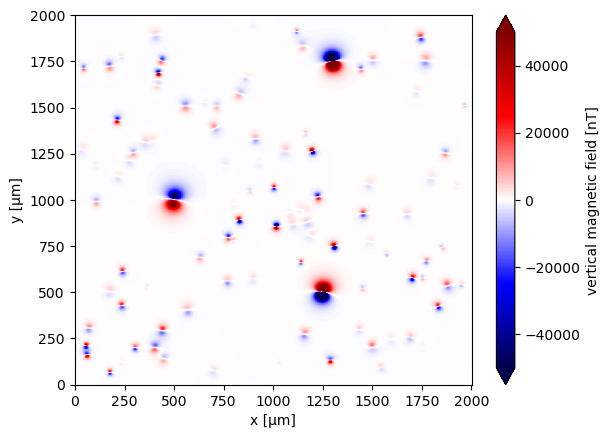

In [10]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999
    tga      (y, x) float64 1.514 1.423 1.934 1.808 ... 1.329 1.596 1.468 1.409
    x_deriv  (y, x) float64 0.739 0.7669 0.52 0.06259 ... -0.2063 0.07748 0.1867
    y_deriv  (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.057 1.13 1.208 1.162
    z_deriv  (y, x) float64 -0.03813 -0.6186 -1.608 ... 1.108 0.8295 0.7746

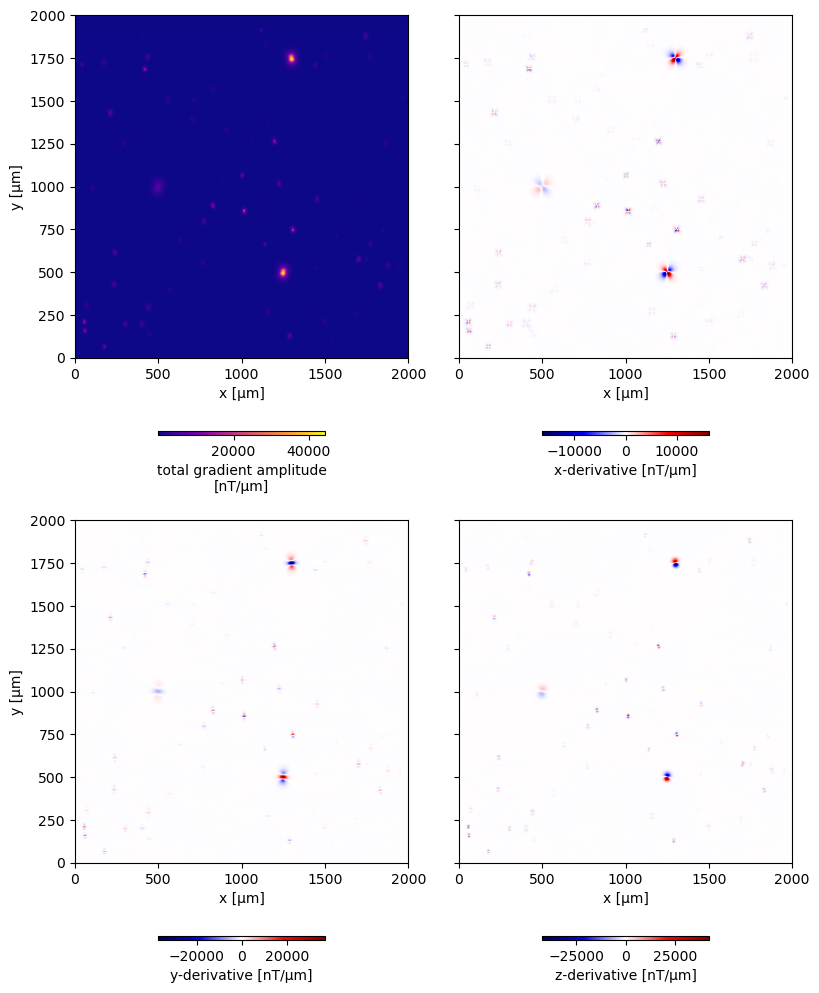

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

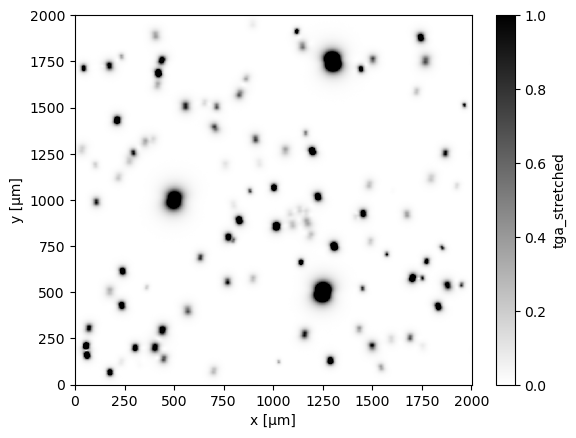

In [14]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [16]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  99


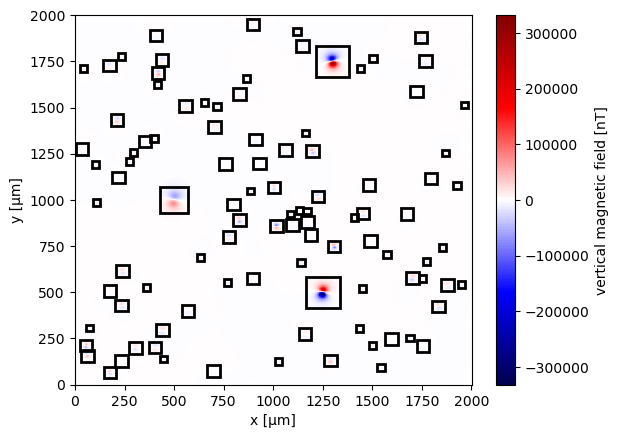

In [17]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# All sources Linear Problem

Run the enhanced Euler Deconvolution and the inversion of all sources.

In [18]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

# fitting parameters
calculated_r2 = []
calculated_SNR = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)


for window in windows:
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values #- base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2 = np.append(calculated_r2, r2)
    calculated_SNR = np.append(calculated_SNR, SNR)

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default i

In [19]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df['z_deriv']

0       -46.425565
1       -50.619468
2       -52.695638
3       -55.178410
4       -59.395332
           ...    
87742   -97.815065
87743   -84.078606
87744   -71.005967
87745   -59.007019
87746   -46.442356
Name: z_deriv, Length: 87747, dtype: float64

In [20]:
positions = np.array([xc_concat, yc_concat, zc_concat])
print(positions)

[[ 1.24999935e+03  1.29999933e+03  1.19800065e+03  1.30800113e+03
   1.01602392e+03  8.29013347e+02  5.00003636e+02  2.13003588e+02
   1.22604860e+03  1.28899893e+03  1.83303009e+03  4.21063732e+02
   1.70325227e+03  2.35849120e+02  1.74502897e+03  1.11889530e+03
   1.00400033e+03  2.39981948e+02  1.13999716e+03  1.45424888e+03
   4.41169745e+02  1.77022570e+02  3.04075990e+02  7.75360898e+02
   1.77401244e+03  4.39898131e+01  4.38010388e+02  6.10802720e+01
   1.44276867e+03  4.05047345e+02  5.70091972e+01  1.87989225e+03
   1.73636335e+02  7.09954847e+01  1.86901342e+03  1.96501949e+03
   1.15899667e+03  2.96119340e+02  7.69955714e+02  1.85299988e+03
   1.49995814e+03  1.07984758e+02  1.57302175e+03  5.58001687e+02
   1.75292106e+03  1.45100807e+03  6.33010997e+02  1.95103113e+03
   8.82995580e+02  9.11044113e+02  7.05889673e+02  1.76898213e+03
   1.50302041e+03  7.14818680e+02  4.48002859e+02  1.69117695e+03
   5.68966763e+02  8.30900749e+02  1.14806202e+03  1.16395357e+03
   4.07024

In [21]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


Calculate dipole moments using all interfering sources.

In [22]:
estimated_dipole_moments = all_dipole_moment_inversion(df, positions)

Calculate predicted data

In [23]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions, estimated_dipole_moments)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

data_up

<xarray.Dataset>
Dimensions:         (y: 1001, x: 1001)
Coordinates:
  * y               (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * x               (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz              (y, x) float64 3.699 5.177 6.767 ... -0.3933 -0.01999
    tga             (y, x) float64 1.514 1.423 1.934 1.808 ... 1.596 1.468 1.409
    x_deriv         (y, x) float64 0.739 0.7669 0.52 ... -0.2063 0.07748 0.1867
    y_deriv         (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.13 1.208 1.162
    z_deriv         (y, x) float64 -0.03813 -0.6186 -1.608 ... 0.8295 0.7746
    tga_stretched   (y, x) float64 0.0006501 0.0005952 ... 0.0006223 0.000587
    predicted_data  (y, x) float64 -4.394 -4.434 -4.475 ... 0.2546 0.2214 0.1893
    error           (y, x) float64 8.093 9.611 11.24 ... -0.5845 -0.6147 -0.2093

Calculate r2 and SNR for all sources.

In [24]:
calculated_r2  = []
calculated_SNR  = []
for window in windows:
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    
    r2  = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    SNR = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    calculated_r2 = np.append(calculated_r2, r2)
    calculated_SNR = np.append(calculated_SNR, SNR)

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [25]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.19249588,  0.19257496,  0.38550978,  0.38521894,  0.39059774,
        0.36211815,  0.11629673,  0.30558359,  0.26940979,  0.32732152,
        0.32463088,  0.5137375 ,  0.35052741,  0.33654473,  0.32458784,
        0.31226569,  0.38835653,  0.32723962,  0.42882592,  0.20748754,
       -0.0086785 ,  0.42529135,  0.3588541 ,  0.52248241,  0.32044322,
        0.33486944,  0.31576397,  0.10435314,  0.26554071,  0.40789882,
        0.43296429,  0.18227594,  0.32089453,  0.26967108,  0.24227229,
        0.42393357,  0.20729772, -0.80081449,  0.33203309,  0.36069928,
        0.40213934,  0.27081623,  0.38934571,  0.2069626 ,  0.39157142,
        0.33578816,  0.25307565,  0.33116351,  0.35803318,  0.22382957,
        0.14970088,  0.19657608,  0.32687987,  0.37171395,  0.27720005,
        0.26690866,  0.20371201,  0.02233464,  0.15801004,  0.32321919,
        0.13680588,  0.26198775,  0.19651575,  0.34488035,  0.30987973,
        3.60828642,  0.15647931,  0.33586508,  0.44107404, -2.06

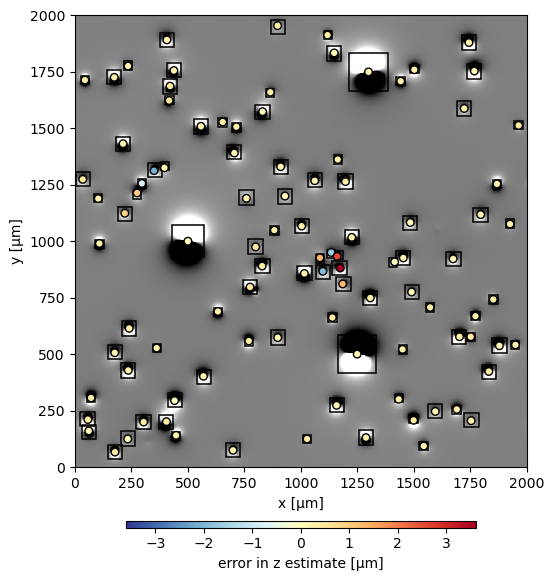

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [27]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest] ):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    # print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    # print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    # print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    # print(f"R²   : {r2:.5f} ")
    # print(f"SNR  : {SNR:.5f} ")
    # print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    # print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    # print()

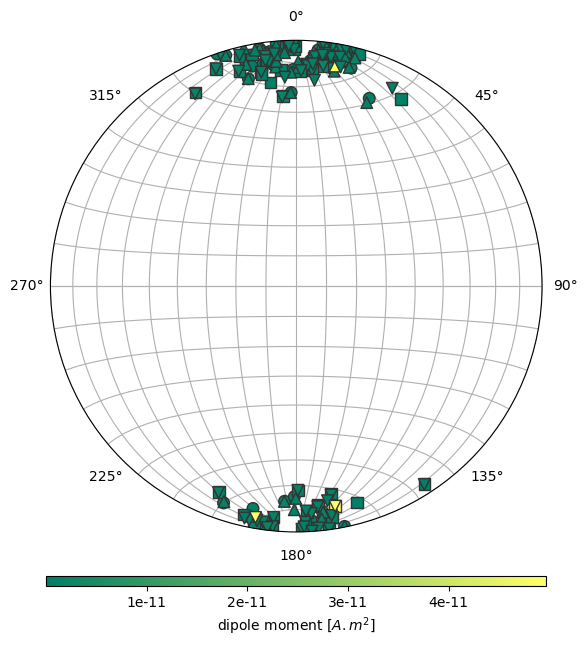

In [28]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [29]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

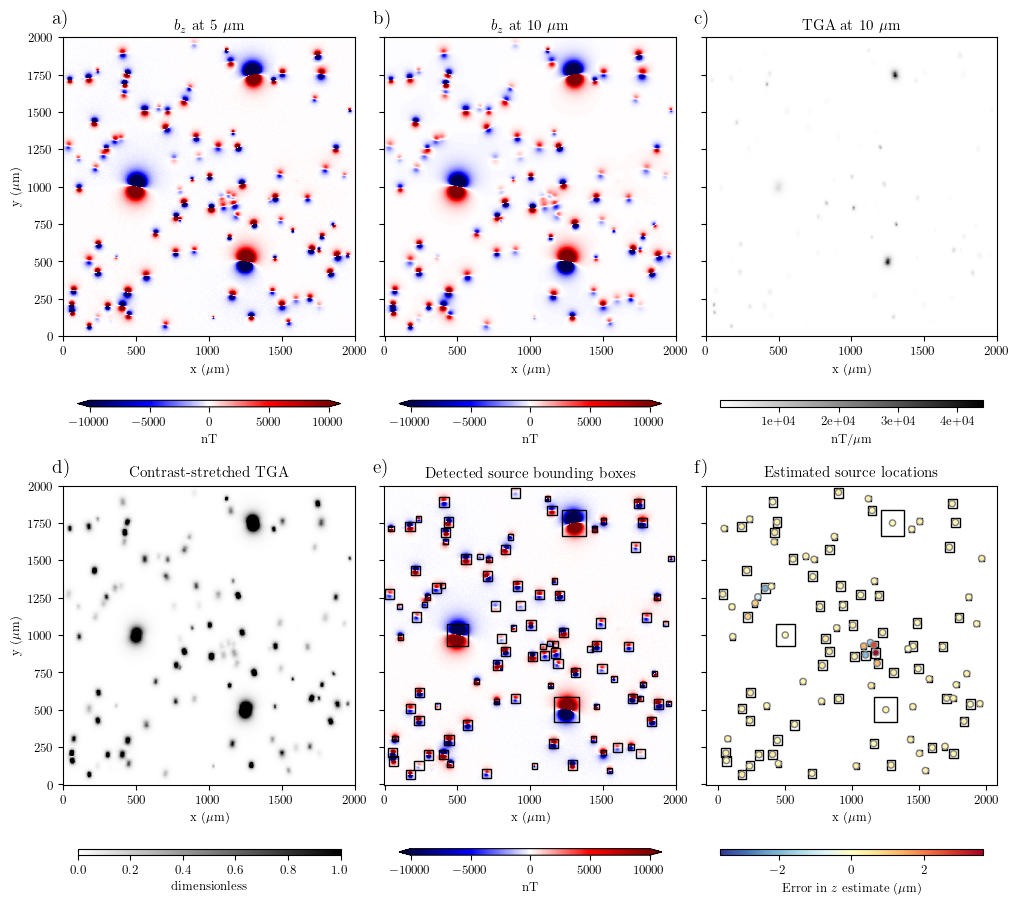

In [30]:
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
#     fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

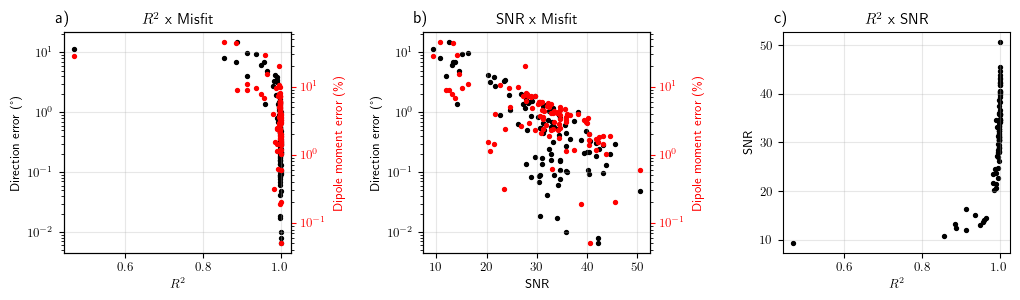

In [31]:
with plt.rc_context(mpl_rc):
    size=8
    fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

    axes = axes.ravel()
    ax = axes[0]
    ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('$R^2$')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[1]
    ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('SNR')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_xlabel('SNR')
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[2]
    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('SNR')

    titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_aspect("auto")
        ax.grid(alpha=0.3, which='major')
        ax.set_title(title)




    plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
#     fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

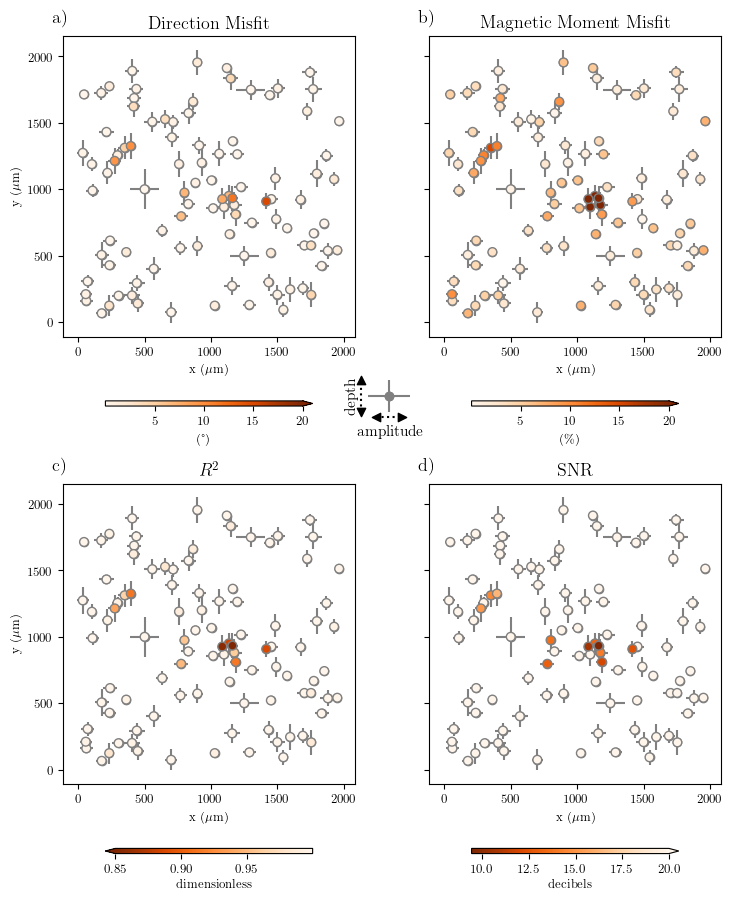

In [32]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 20
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
    ax5 = fig.add_axes([left, bottom, width, height])
    ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
                 fmt='o', zorder=0, color='gray')
    ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
    ax5.set_ylim(-1.0, 1.5)
    ax5.set_xlim(-0.6, 1.1)

    ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
    ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
    ax5.scatter(-0.15, -0.0, marker='v', color='k')
    ax5.scatter(-0.15, 1.0, marker='^', color='k')

    ax5.scatter(0.2,-0.15, marker='<', color='k')
    ax5.scatter(0.8,-0.15, marker='>', color='k')

    ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
    ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

    ax5.set_title('', loc='left')
    # Eliminate upper and right axes
    ax5.spines['right'].set_color('none')
    ax5.spines['top'].set_color('none')
    ax5.spines['bottom'].set_color('none')
    ax5.spines['left'].set_color('none')
    ax5.xaxis.set_ticks([])
    ax5.yaxis.set_ticks([])
    
#     fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()


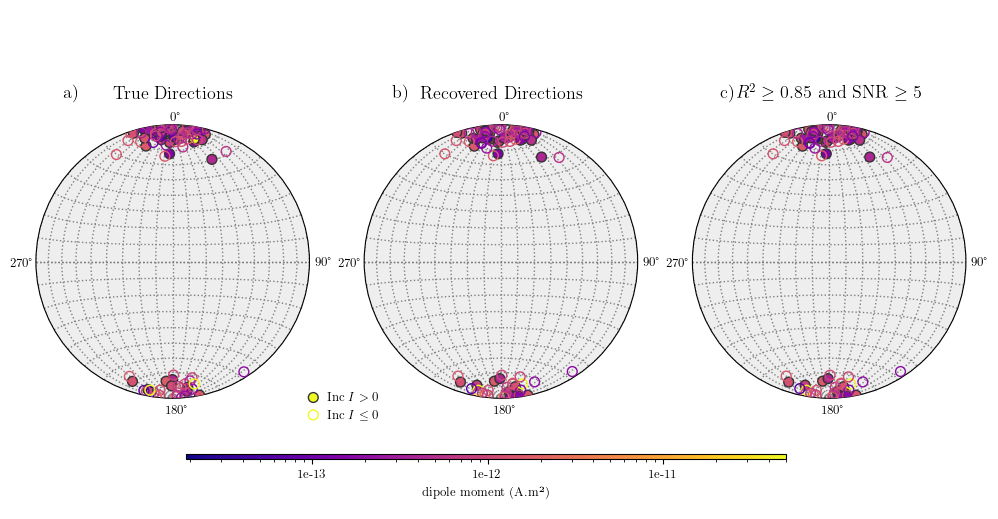

In [33]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(12, 5))
    axes = []
    
    ax = fig.add_subplot(1, 3, 1, projection='stereonet')
    axes.append(ax)    
    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min((np.min(estimated), np.min(true)))
    vmax = np.max((np.max(estimated), np.max(true)))
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs)

    
    ax = fig.add_subplot(1, 3, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(-0.25, -0.1), frameon=False, handletextpad=0.1)
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.1, 0.5, 0.01]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(1, 3, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2)

    plt.show()


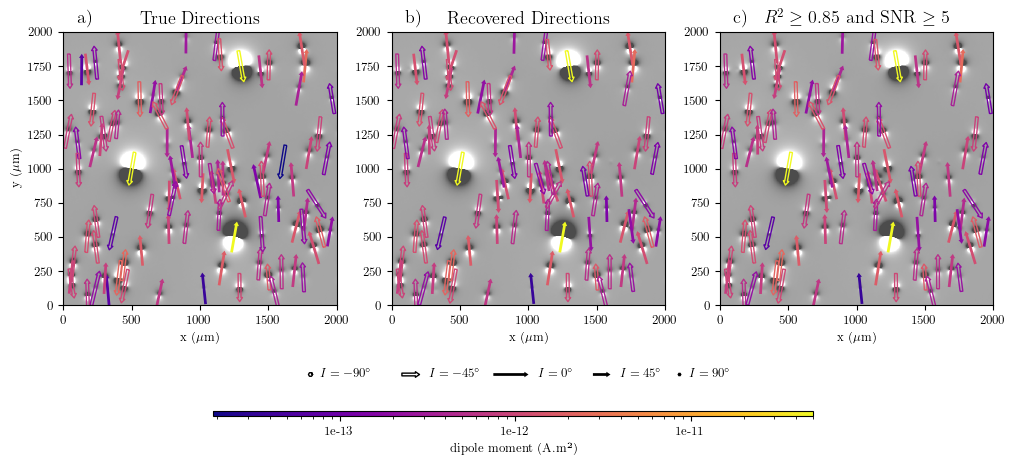

In [34]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(12, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min( (np.min(estimated), np.min(true)))
    vmax = np.max( (np.max(estimated), np.max(true)))
    cmap = "plasma"

    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
    ax = fig.add_subplot(1, 3, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        dipole_coordinates, dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")
    
    
    ax = fig.add_subplot(1, 3, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")

    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k')
    
    
    
    
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(1, 3, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")
    
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.0, 0.5, 0.01]), 
        format="%.0e",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.2)
    
    plt.show()


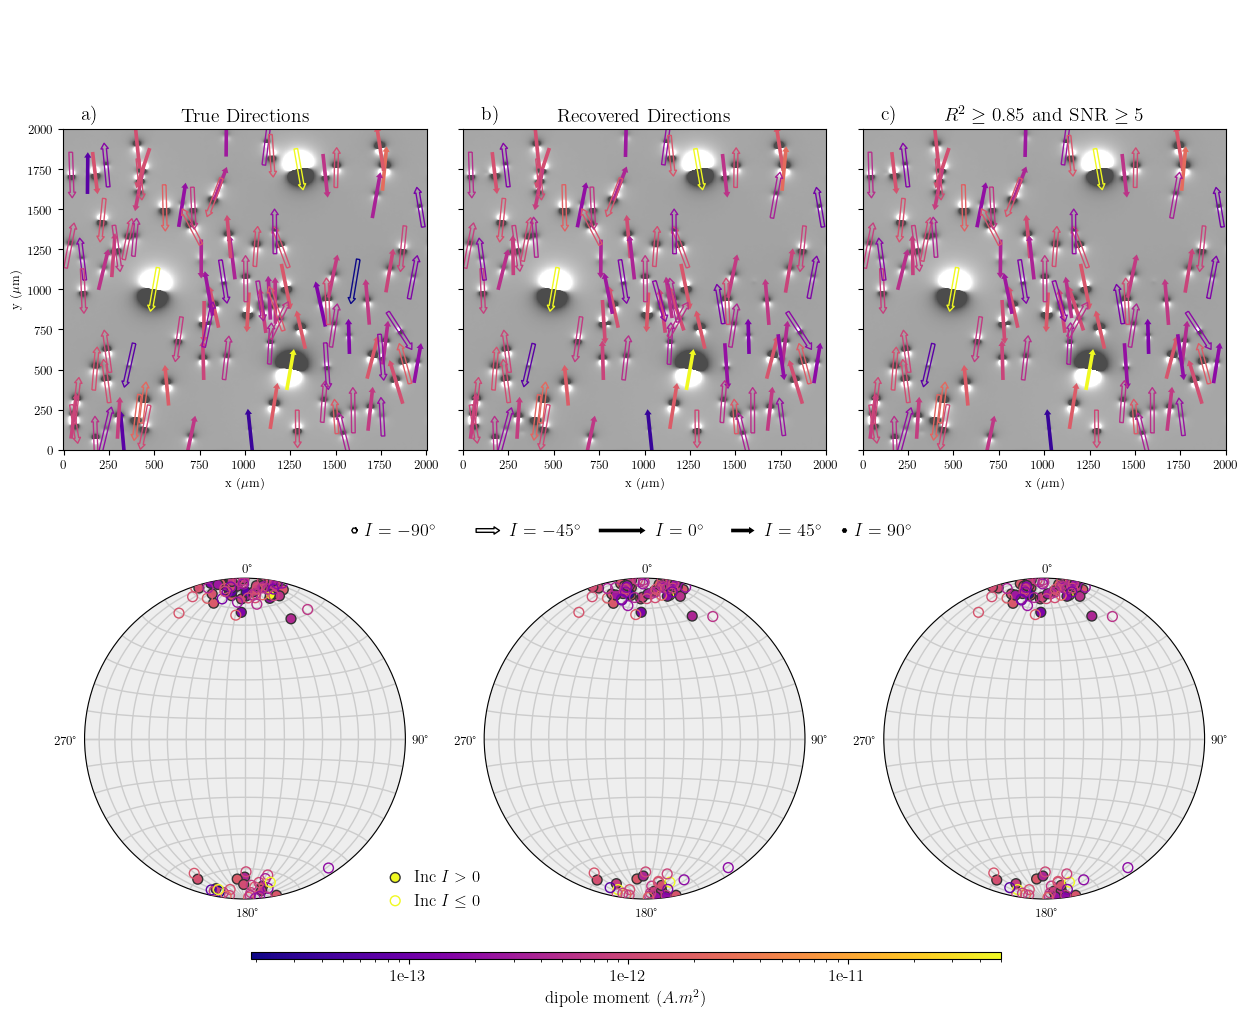

In [35]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 10))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min( (np.min(estimated), np.min(true)))
    vmax = np.max( (np.max(estimated), np.max(true)))
    cmap = "plasma"

    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    ax = fig.add_subplot(2, 3, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
 
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        dipole_coordinates, dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    
    
    ax = fig.add_subplot(2, 3, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    plt.yticks(color='w')
    
    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(2, 3, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    plt.yticks(color='w')
    
    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=12)
    
    clb.ax.tick_params(labelsize=12)
    
#################################################################################################
#                                           Stereograms
#################################################################################################

    ax = fig.add_subplot(2, 3, 4, projection='stereonet')
    axes.append(ax)    
    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min((np.min(estimated), np.min(true)))
    vmax = np.max((np.max(estimated), np.max(true)))
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs, add_ticks=True)

    
    ax = fig.add_subplot(2, 3, 5, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})

    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(2, 3, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    
    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.1, hspace=0.4)
#     fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

### Show the observed and predicted data

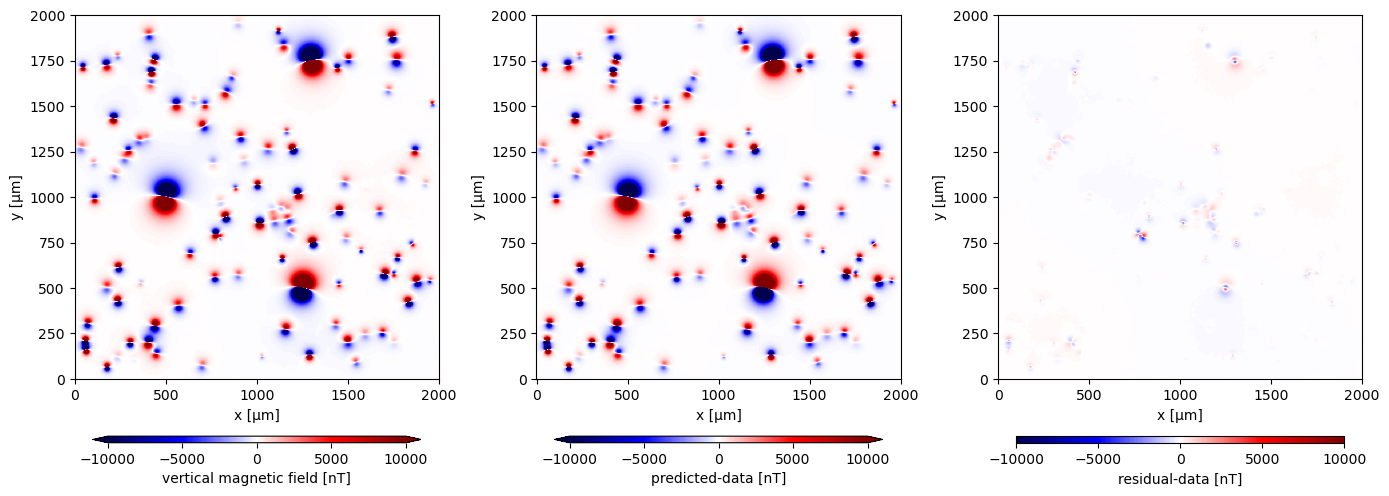

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 15 windows

All modeled sources: R2 = 0.9999366696837251 and SNR = 42.186138959332446
Individual source:   R2 = 0.9999366696837251 and SNR = 42.186138959332446


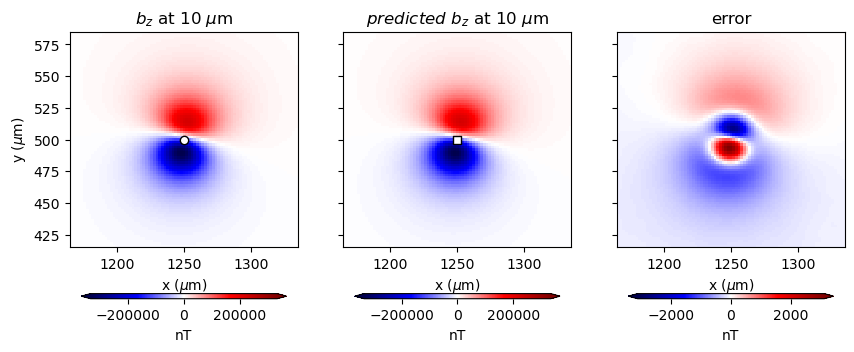

All modeled sources: R2 = 0.9999363115831404 and SNR = 42.24498976916416
Individual source:   R2 = 0.9999363115831404 and SNR = 42.24498976916416


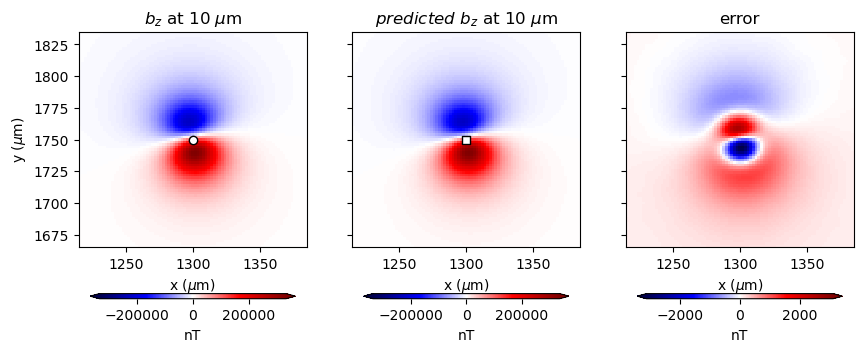

All modeled sources: R2 = 0.9991160958758201 and SNR = 30.577507457968707
Individual source:   R2 = 0.9991160958758201 and SNR = 30.577507457968707


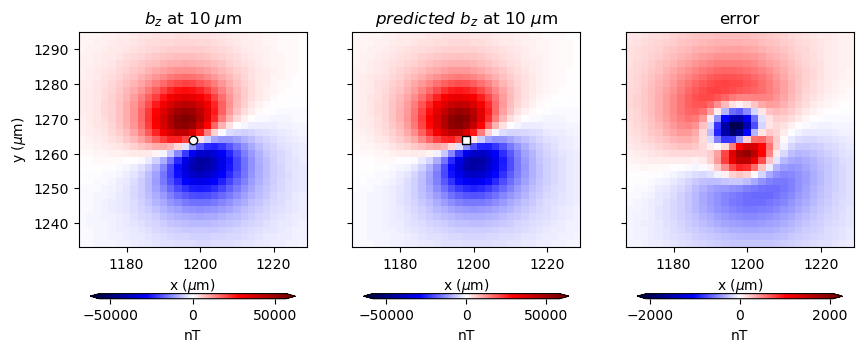

All modeled sources: R2 = 0.9990984230593083 and SNR = 30.57959286828354
Individual source:   R2 = 0.9990984230593083 and SNR = 30.57959286828354


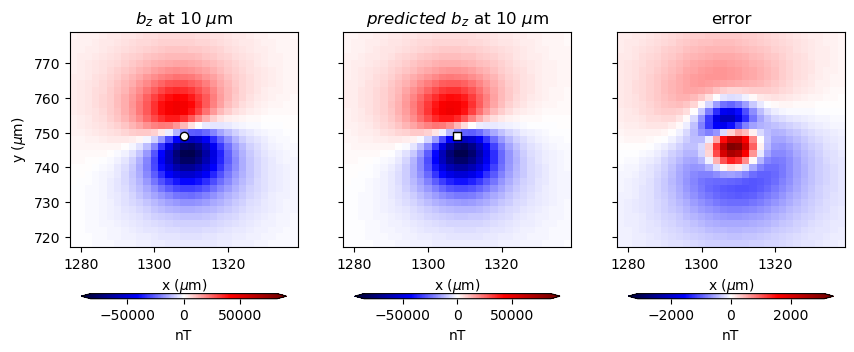

All modeled sources: R2 = 0.9990535146561589 and SNR = 30.454557922184726
Individual source:   R2 = 0.9990535146561589 and SNR = 30.454557922184726


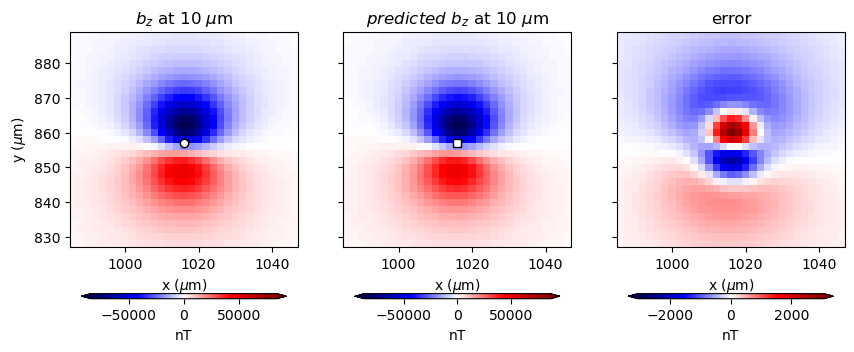

All modeled sources: R2 = 0.9992940963080853 and SNR = 31.938389447321264
Individual source:   R2 = 0.9992940963080853 and SNR = 31.938389447321264


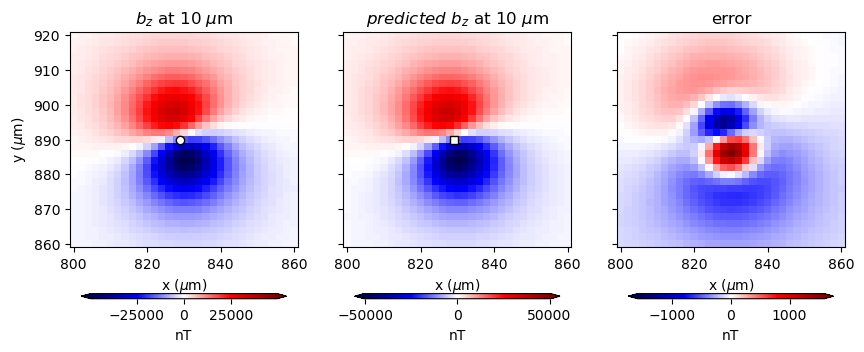

All modeled sources: R2 = 0.9999878477524168 and SNR = 50.573026375132095
Individual source:   R2 = 0.9999878477524168 and SNR = 50.573026375132095


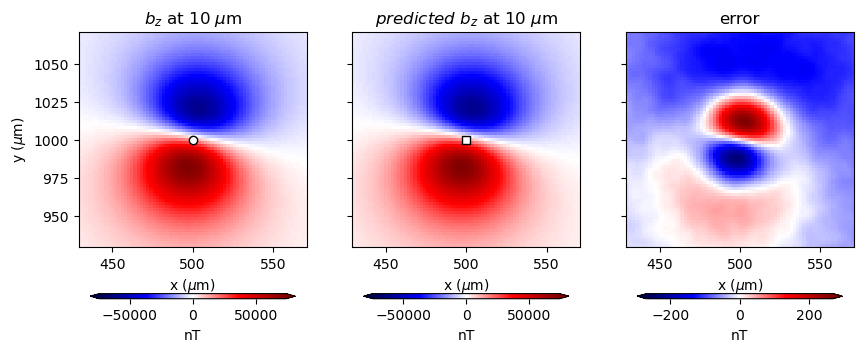

All modeled sources: R2 = 0.999620907944353 and SNR = 34.57992316243756
Individual source:   R2 = 0.999620907944353 and SNR = 34.57992316243756


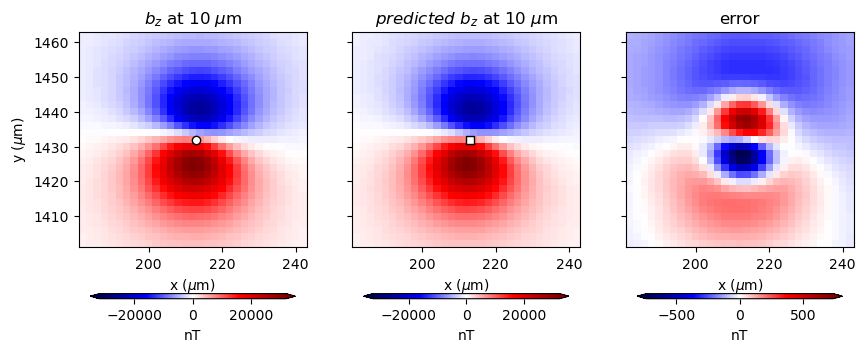

All modeled sources: R2 = 0.9997421815360374 and SNR = 35.900771913384645
Individual source:   R2 = 0.9997421815360374 and SNR = 35.900771913384645


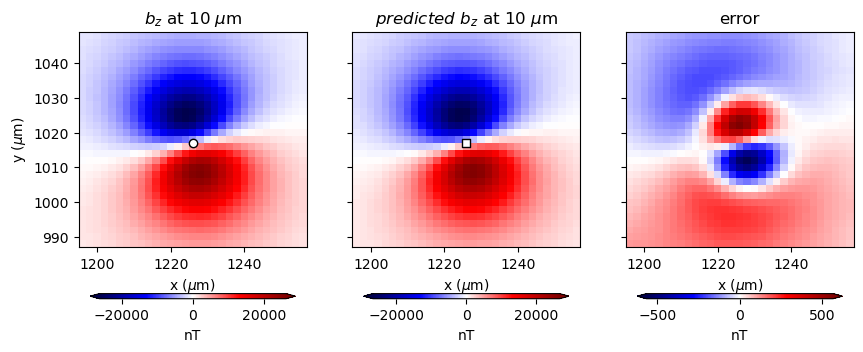

All modeled sources: R2 = 0.9995442276855001 and SNR = 33.481671375231045
Individual source:   R2 = 0.9995442276855001 and SNR = 33.481671375231045


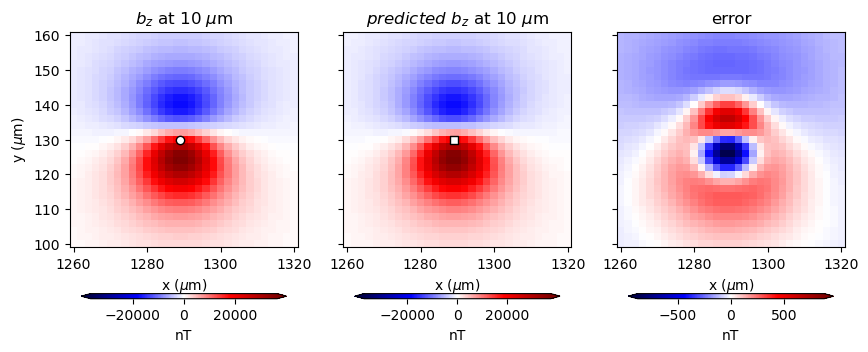

All modeled sources: R2 = 0.9996112013681655 and SNR = 34.10880700978235
Individual source:   R2 = 0.9996112013681655 and SNR = 34.10880700978235


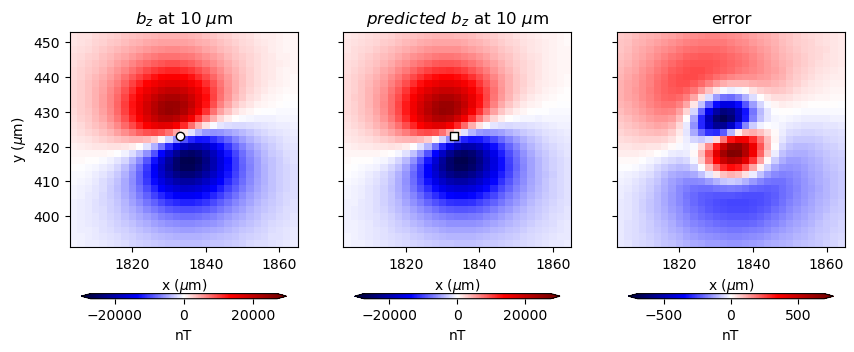

All modeled sources: R2 = 0.998384228566485 and SNR = 27.922860433231552
Individual source:   R2 = 0.998384228566485 and SNR = 27.922860433231552


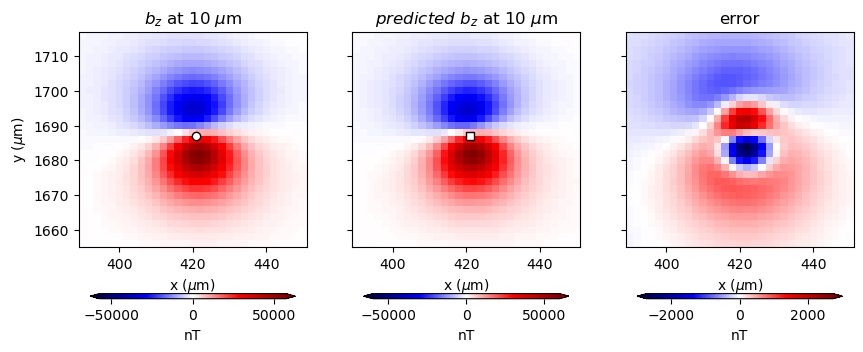

All modeled sources: R2 = 0.9992191965339206 and SNR = 31.081765693737072
Individual source:   R2 = 0.9992191965339206 and SNR = 31.081765693737072


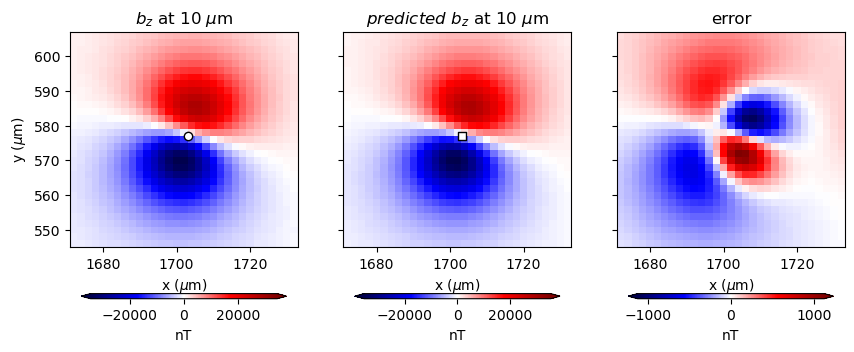

All modeled sources: R2 = 0.9994398922034402 and SNR = 33.27365916798965
Individual source:   R2 = 0.9994398922034402 and SNR = 33.27365916798965


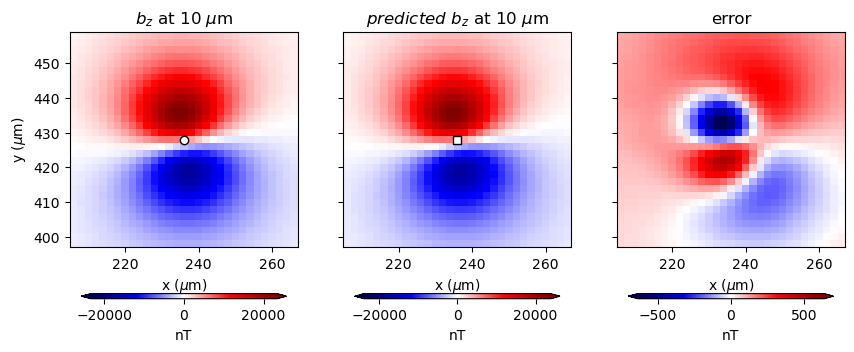

All modeled sources: R2 = 0.9997351917867554 and SNR = 35.82508132563022
Individual source:   R2 = 0.9997351917867554 and SNR = 35.82508132563022


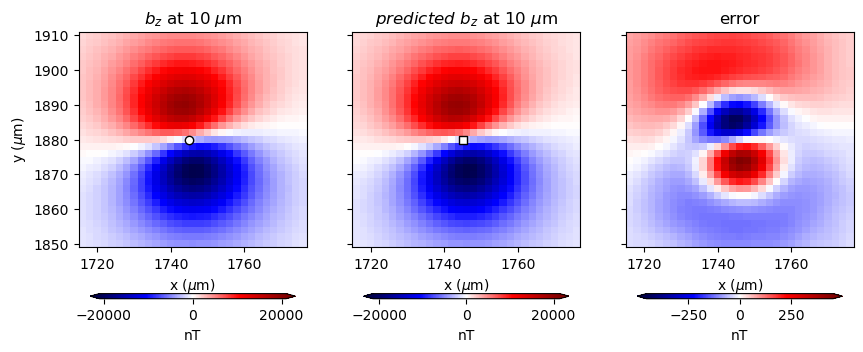

In [37]:
for window, r2, SNR in zip(windows[0:15], calculated_r2[0:15], calculated_SNR[0:15]):
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(positions[0], positions[1], color='w', marker='s', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))
    print(r"Individual source:   R2 = %s and SNR = %s"%(r2, SNR))

    plt.show()